## Imports

In [210]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.models import load_model 

In [211]:
FOCUS_SOURCE_DIR = "dataset_2/focus/"
UNFOCUS_SOURCE_DIR = "dataset_2/unfocus/"
#DROWSY_SOURCE_DIR = "dataset/drowsy/"

TRAINING_DIR = 'images_2/training/'
VALIDATION_DIR = 'images_2/validation/'

TRAINING_FOCUS_DIR = os.path.join(TRAINING_DIR, "focus/")
VALIDATION_FOCUS_DIR = os.path.join(VALIDATION_DIR, "focus/")

TRAINING_UNFOCUS_DIR = os.path.join(TRAINING_DIR, "unfocus/")
VALIDATION_UNFOCUS_DIR = os.path.join(VALIDATION_DIR, "unfocus/")

#TRAINING_DROWSY_DIR = os.path.join(TRAINING_DIR, "drowsy/")
#VALIDATION_DROWSY_DIR = os.path.join(VALIDATION_DIR, "drowsy/")


In [177]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  files = []
  for filename in os.listdir(SOURCE_DIR):
    file = SOURCE_DIR + filename
    if os.path.getsize(file)>0:
      files.append(filename)
    else:
      print(filename +" is zero length, so ignoring.")

    training_length = int(len(files)*SPLIT_SIZE)
    testing_length = int(len(files)-training_length)
    random_set = random.sample(files,len(files))
    training_set = random_set[0:training_length]
    testing_set = random_set[training_length:]

  for filename in training_set:
    curr_file = SOURCE_DIR + filename
    target_dir = TRAINING_DIR + filename
    copyfile(curr_file,target_dir)

  for filename in testing_set:
    curr_file = SOURCE_DIR + filename
    target_dir = VALIDATION_DIR + filename
    copyfile(curr_file,target_dir)
  pass

 

In [13]:
# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_FOCUS_DIR)) > 0:
  for file in os.scandir(TRAINING_FOCUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_UNFOCUS_DIR)) > 0:
  for file in os.scandir(TRAINING_UNFOCUS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DROWSY_DIR)) > 0:
  for file in os.scandir(TRAINING_DROWSY_DIR):
    os.remove(file.path)

if len(os.listdir(VALIDATION_FOCUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_FOCUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_UNFOCUS_DIR)) > 0:
  for file in os.scandir(VALIDATION_UNFOCUS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DROWSY_DIR)) > 0:
  for file in os.scandir(VALIDATION_DROWSY_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .7

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(FOCUS_SOURCE_DIR, TRAINING_FOCUS_DIR, VALIDATION_FOCUS_DIR, split_size)
split_data(UNFOCUS_SOURCE_DIR, TRAINING_UNFOCUS_DIR, VALIDATION_UNFOCUS_DIR, split_size)
#split_data(DROWSY_SOURCE_DIR, TRAINING_DROWSY_DIR, VALIDATION_DROWSY_DIR, split_size)
# Check that the number of images matches the expected output



In [212]:
# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"Original focus's directory has {len(os.listdir(FOCUS_SOURCE_DIR))} images")
print(f"Original unfocus's directory has {len(os.listdir(UNFOCUS_SOURCE_DIR))} images")
#print(f"Original drowsy's directory has {len(os.listdir(DROWSY_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_FOCUS_DIR))} images of focus for training")
print(f"There are {len(os.listdir(TRAINING_UNFOCUS_DIR))} images of unfocus for training")
#print(f"There are {len(os.listdir(TRAINING_DROWSY_DIR))} images of drowsy for training\n")

print(f"There are {len(os.listdir(VALIDATION_FOCUS_DIR))} images of focus for validation")
print(f"There are {len(os.listdir(VALIDATION_UNFOCUS_DIR))} images of unfocus for validation")
#print(f"There are {len(os.listdir(VALIDATION_DROWSY_DIR))} images of drowsy for validation")

Original focus's directory has 12870 images
Original unfocus's directory has 12870 images
There are 9009 images of focus for training
There are 9009 images of unfocus for training
There are 3861 images of focus for validation
There are 3861 images of unfocus for validation


In [196]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale=1.0/255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary', #categorical
                                                      target_size=(224, 224)
                                                      )

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary', # categorical
                                                                target_size=(224,224)
                                                                )
  ### END CODE HERE
  return train_generator, validation_generator

In [197]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 18018 images belonging to 2 classes.
Found 7722 images belonging to 2 classes.


In [214]:
np.random.seed(42)
tf.random.set_seed(42)

In [213]:
#  input to vgg16 is 224x224 with rgb, batch_size=32
HEIGHT=224
WIDTH=224
BATCH_SIZE=20

In [215]:
# rescale pixel value [0,1]
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# for an augmentation we can use
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    zoom_range=0.1,
#                                    rotation_range=20,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    horizontal_flip = True)

One of "categorical", "binary", "sparse", "input", or None. Determines the type of label arrays that are returned:
- "categorical" will be 2D one-hot encoded labels,
- "binary" will be 1D binary labels,
- "sparse" will be 1D integer labels,
- "input" will be images identical to input images (mainly used to work with autoencoders).

If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly. Defaults to "categorical".

In [216]:
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    #classes={'focus': 0, 'unfocus': 1,'drowsy': 2}
    )

test_generator = test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    #classes={'focus': 0, 'unfocus': 1,'drowsy': 2}
    )

# shuffle=True will shuffle the images and labels within each batch
#  but the correspondence between the images and labels will be maintained.

Found 18018 images belonging to 2 classes.
Found 7722 images belonging to 2 classes.


In [145]:
total_image = np.concatenate([train_generator.labels,test_generator.labels])

In [217]:
print('focus: ',len(np.where(total_image==0)[0]))
print('unfocus: ',len(np.where(total_image==1)[0]))
#print('drowsy: ',len(np.where(total_image==2)[0]))

focus:  12870
unfocus:  12870


In [218]:
train_generator.labels.shape

(18018,)

In [219]:
# multiclass classification - 3 classes
np.unique(train_generator.labels)

array([0, 1], dtype=int32)

## Display Images

In [55]:
images, labels = next(train_generator)

In [56]:
# per batch
labels.shape

(32,)

In [57]:
def plot_images(images_arr, labels_arr, class_indices):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = list(class_indices.keys())[list(class_indices.values()).index(int(lbl))]
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

In [58]:
labels[:5]

array([1., 2., 1., 1., 0.], dtype=float32)

In [ ]:
# Display first 5 images from the batch
plot_images(images[:5], labels[:5], train_generator.class_indices)

# Implementing VGG16 - Transfer Learning

- For binary: sigmoid in last layer
- For multiclass: softmax in last layer

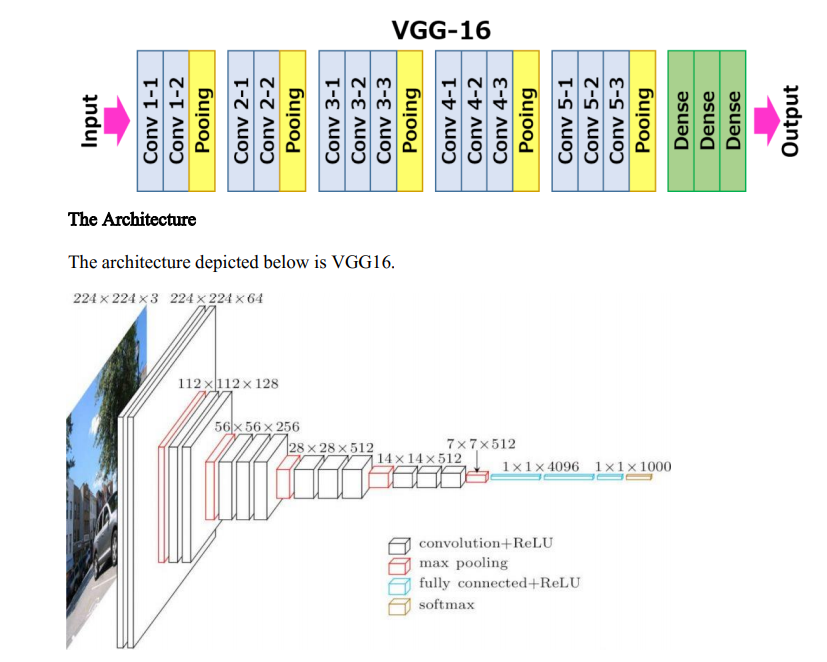

In [220]:
tf.keras.backend.clear_session()

In [221]:
# Loading VGG16 Model with Pre-trained Weights - without final (top) later as we will customize it
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(HEIGHT, WIDTH, 3))

In [222]:
# Freeze the layers of the base model
# so that ony final layer learns from new dataset
for layer in base_model.layers:
    layer.trainable = False

In [223]:
num_classes = len(train_generator.class_indices)
print('Number of classes:', num_classes)

Number of classes: 2


In [224]:
# 3. Fine-tune the Model
model = Sequential()
model.add(base_model)
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

#
model.add(Dense(1, activation='sigmoid'))


In [225]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

- SparseCategoricalCrossentropy: This loss function is used when the target labels are integers, e.g., [0, 2, 1, ...] where each integer corresponds to a class. So, if you have 3 classes, the labels would be 0, 1, or 2.
- CategoricalCrossentropy: This loss function is used when the target labels are one-hot encoded, e.g., for three classes, the labels would look like: [[1, 0, 0], [0, 0, 1], [0, 1, 0], ...]

In [226]:
#tf.keras.utils.plot_model(model, to_file='vgg16-image-classifier.png', show_shapes=True, show_layer_names=True)

In [227]:
from tensorflow.keras.optimizers.legacy import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [68]:
# def f1_score(y_true, y_pred):
#     def recall(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

#     def precision(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

#     precision_val = precision(y_true, y_pred)
#     recall_val = recall(y_true, y_pred)
#     return 2*((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))


# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=[f1_score])


## Adding Callbacks

In [228]:
checkpoint = ModelCheckpoint('vgg16_best_weights.keras',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=50)

callbacks_list = [checkpoint,early]

## Training model
Model weights will be saved to a file called `vgg16_best_weights.h5` whenever there is an improvement in validation accuracy.
After training we can load these weights back into model using `model.load_weights('vgg16_best_weights.h5')`

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[callbacks_list],
        steps_per_epoch = 100,
        validation_steps = 50,
        verbose = 2)

In [206]:
model.save('models/vgg16_complete_model.keras')

## Plotting the results

In [207]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

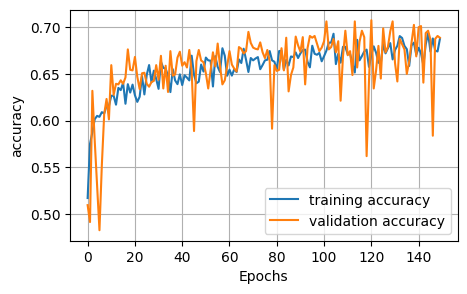

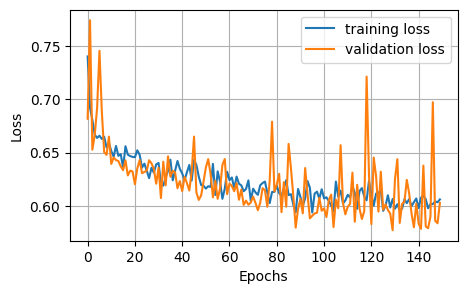

In [208]:
plot_learning_curve(history, metrics='accuracy')

In [209]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
#model.compile(optimizer=keras.optimizers.legacy.Adam(1e-5),  # Very low learning rate
#              loss=keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=[keras.metrics.BinaryAccuracy()])

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train end-to-end. Be careful to stop before you overfit!
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[callbacks_list],
        steps_per_epoch = 100,
        validation_steps = 50,
        verbose = 2)

Epoch 1/100

Epoch 1: val_accuracy did not improve from 0.70750
100/100 - 71s - loss: 12693.8623 - accuracy: 0.5080 - val_loss: 133.2374 - val_accuracy: 0.5019 - 71s/epoch - 709ms/step
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.70750
100/100 - 67s - loss: 12801188.0000 - accuracy: 0.4960 - val_loss: 569624.8125 - val_accuracy: 0.4894 - 67s/epoch - 670ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.70750
100/100 - 75s - loss: 78153544.0000 - accuracy: 0.5040 - val_loss: 19.9602 - val_accuracy: 0.5056 - 75s/epoch - 752ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.70750
100/100 - 80s - loss: 471097248.0000 - accuracy: 0.4725 - val_loss: 1358511616.0000 - val_accuracy: 0.4913 - 80s/epoch - 802ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.70750
100/100 - 80s - loss: 1109755648.0000 - accuracy: 0.5050 - val_loss: 5026094.5000 - val_accuracy: 0.5038 - 80s/epoch - 803ms/step
Epoch 6/100

Epoch 6: val_accuracy did not impr

KeyboardInterrupt: 

## Evaluate Model

In [113]:
train_result = model.evaluate(train_generator)
test_result = model.evaluate(test_generator)

362/362 [==============================] - 85s 234ms/step - loss: 23.9568 - accuracy: 0.3333


In [114]:
print(f"Train Loss: {np.round(train_result[0], 4)}")
print(f"Test Loss: {np.round(test_result[0], 4)}")
print(f"Train Accuracy: {np.round(train_result[1], 3)}")
print(f"Test Accuracy: {np.round(test_result[1], 3)}")

Train Loss: 23.9458
Test Loss: 23.9568
Train Accuracy: 0.333
Test Accuracy: 0.333


In [115]:
y_pred_probs = model.predict(test_generator)
print(y_pred_probs.shape)

362/362 [==============================] - 83s 229ms/step
(11583, 3)


In [116]:
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [117]:
y_true.shape

(11583,)

In [118]:
print('focus: ',len(np.where(y_true==0)[0]))
print('unfocus: ',len(np.where(y_true==1)[0]))
print('drowsy: ',len(np.where(y_true==2)[0]))

focus:  3861
unfocus:  3861
drowsy:  3861


In [119]:
y_pred_probs = model.predict(test_generator)

362/362 [==============================] - 92s 254ms/step


In [120]:
classes_names = list(test_generator.class_indices.keys())

In [121]:
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", confusion)
# Calculate perfect confusion matrix
p_confusion = confusion_matrix(y_true, y_true)
print("Perfect Confusion Matrix:\n", p_confusion)
# Calculate precision, recall, and f1-score
report = classification_report(y_true, y_pred, target_names=classes_names)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[   0    0 3861]
 [   0    0 3861]
 [   0    0 3861]]
Perfect Confusion Matrix:
 [[3861    0    0]
 [   0 3861    0]
 [   0    0 3861]]

Classification Report:
               precision    recall  f1-score   support

       focus       0.00      0.00      0.00      3861
     unfocus       0.00      0.00      0.00      3861
      drowsy       0.33      1.00      0.50      3861

    accuracy                           0.33     11583
   macro avg       0.11      0.33      0.17     11583
weighted avg       0.11      0.33      0.17     11583



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

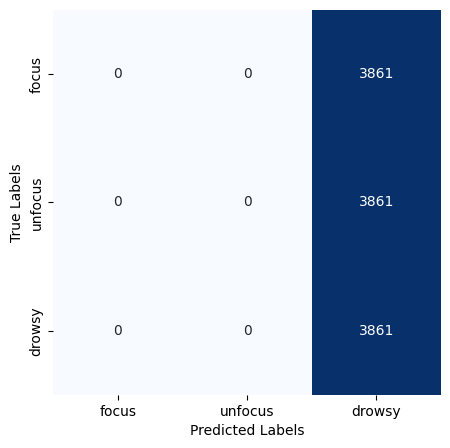

In [122]:
plt.figure(figsize=(5, 5))
hmap = sns.heatmap(confusion, annot=True, vmin=0,
                 fmt='g', cmap='Blues', cbar=False,
                 xticklabels=classes_names,
                 yticklabels=classes_names)

hmap.set(xlabel='Predicted Labels')
hmap.set(ylabel='True Labels')
plt.show()

In [84]:
#Extract wrong classification index
wrong_pred = np.where(y_pred!=y_true)[0]
print(f'Total of {len(wrong_pred)} missclassified images')
print('Missclassified images index: ',wrong_pred)

Total of 2 missclassified images
Missclassified images index:  [ 7 12]


In [85]:
images, true_labels = next(test_generator)

In [86]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [ ]:

class_map = {0: 'Normal', 1: 'Viral Pneumonia', 2: 'Covid'}

plt.figure(figsize=(10, 5))
for i, index in enumerate(wrong_pred):
    plt.subplot(1, len(wrong_pred), i + 1)

    # reverting scalling (done in preprocessing stage)
    plt.imshow((images[index]*255).astype('uint8'))

    plt.text(5, 10, f"True: {class_map[int(true_labels[index])]}",
             color='green', bbox=dict(facecolor='white', alpha=0.6))
    plt.text(5, 30, f"Pred: {class_map[y_pred[index]]}",
             color='red', bbox=dict(facecolor='white', alpha=0.6))

    plt.axis('off')
plt.tight_layout()
plt.show()